In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import (
    make_column_transformer,
    make_column_selector,
    ColumnTransformer,
)

from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn import set_config

set_config(display="diagram")

#### Auxiliary variables

In [4]:
filename_input = "data-hdma-eastbay-2019-2022-processed"
filename_output = "data-hdma-eastbay-2019-2022-sklearn"

#### Loading the processed data

In [5]:
df = pd.read_csv(f"../../{filename_input}.csv", index_col=0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222872 entries, 0 to 222871
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   debt_to_income_ratio_df            222872 non-null  float64
 1   property_value                     222872 non-null  float64
 2   loan_term                          222872 non-null  float64
 3   loan_to_value_ratio                222872 non-null  float64
 4   loan_amount                        222872 non-null  float64
 5   income                             222872 non-null  float64
 6   tract_minority_population_percent  222872 non-null  float64
 7   tract_to_msa_income_percentage     222872 non-null  float64
 8   tract_population                   222872 non-null  float64
 9   tract_one_to_four_family_homes     222872 non-null  float64
 10  tract_median_age_of_housing_units  222872 non-null  float64
 11  tract_owner_occupied_units         222872 no

## 3. Preparing for modeling

### 3.1. Lists of feature names

In [7]:
tract_features = [x for x in df.columns if x.startswith("tract_")]

numerical_loan_features = [
    "debt_to_income_ratio",
    "debt_to_income_ratio_df",
    "loan_term",
    "loan_to_value_ratio",
]
numerical_currency_features = ["property_value", "income", "loan_amount"]
numerical_sqrt_currency_features = [
    "sqrt_income",
    "sqrt_property_value",
    "sqrt_loan_amount",
]
categorical_applicant_features = [
    "applicant_sex",
    "applicant_race",
    "applicant_ethnicity",
    "applicant_age",
]
categorical_coapplicant_features = [
    "coapplicant_sex",
    "coapplicant_race",
    "coapplicant_ethnicity",
    "coapplicant_age",
]
categorical_loan_features = [
    "conforming_loan_limit",
    "occupancy_type",
    # "hoepa_status",
    "lien_status",
    "loan_purpose",
    "loan_type",
]
binary_features = [
    "applicant_age_above_62",
    "interest_only_payment",
    "business_or_commercial_purpose",
    "open-end_line_of_credit",
]

derived_features = [
    "derived_sex",
    "derived_race",
    "derived_ethnicity",
    "derived_loan_product_type",
]

target_related_features = ["denial_reason"]

target_feature = "application_outcome"

### 3.3. X,y

In [8]:
X = df[
    numerical_loan_features
    + numerical_currency_features
    # + numerical_sqrt_currency_features
    # + categorical_applicant_features
    # + categorical_coapplicant_features
    + categorical_loan_features
    + binary_features
    # + derived_features
]
y = df[target_feature]

categorical_columns = X.select_dtypes(include=object).columns
numerical_columns = X.select_dtypes(include=float).columns

print(categorical_columns)
print(numerical_columns)

X.loc[:, categorical_columns] = X.loc[:, categorical_columns].astype('category')

Index(['conforming_loan_limit', 'occupancy_type', 'lien_status',
       'loan_purpose', 'loan_type', 'applicant_age_above_62',
       'interest_only_payment', 'business_or_commercial_purpose',
       'open-end_line_of_credit'],
      dtype='object')
Index(['debt_to_income_ratio', 'debt_to_income_ratio_df', 'loan_term',
       'loan_to_value_ratio', 'property_value', 'income', 'loan_amount'],
      dtype='object')


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222872 entries, 0 to 222871
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   debt_to_income_ratio            222872 non-null  float64
 1   debt_to_income_ratio_df         222872 non-null  float64
 2   loan_term                       222872 non-null  float64
 3   loan_to_value_ratio             222872 non-null  float64
 4   property_value                  222872 non-null  float64
 5   income                          222872 non-null  float64
 6   loan_amount                     222872 non-null  float64
 7   conforming_loan_limit           222872 non-null  object 
 8   occupancy_type                  222872 non-null  object 
 9   lien_status                     222872 non-null  object 
 10  loan_purpose                    222872 non-null  object 
 11  loan_type                       222872 non-null  object 
 12  applicant_age_above_6

In [10]:
def main_column_transformer():
    return ColumnTransformer(
        [
            # ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )

def total_column_transformer():
    return ColumnTransformer(
        [
            ("ohe", OneHotEncoder(sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    
preprocessor = main_column_transformer().set_output(transform="pandas")
X_scaled = preprocessor.fit_transform(X)

total_preprocessor = total_column_transformer().set_output(transform="pandas")
X_transformed = total_preprocessor.fit_transform(X)

In [11]:
X_scaled.head()

,debt_to_income_ratio,debt_to_income_ratio_df,loan_term,loan_to_value_ratio,property_value,income,loan_amount,conforming_loan_limit,occupancy_type,lien_status,loan_purpose,loan_type,applicant_age_above_62,interest_only_payment,business_or_commercial_purpose,open-end_line_of_credit
0,0.230299,-0.327008,0.336612,1.646714,-1.417409,-0.573696,-0.580370,C,Main residence,First,Home purchase,Conventional,No,No,No,No
1,0.378440,0.403615,0.336612,0.392931,-1.268580,-0.904684,-0.627263,C,Investment property,First,Cash-out refinancing,Conventional,No,No,Yes,No
2,1.193218,1.188801,0.336612,1.370872,-0.375601,-0.426590,0.732636,C,Main residence,First,Home purchase,FHA,No,No,No,No
3,-1.028902,-0.689797,0.336612,0.022643,-0.921310,0.057633,-0.392798,C,Main residence,First,Refinancing,Conventional,No,No,No,No
4,1.193218,0.323167,0.336612,-0.838864,-0.607114,-0.775966,-0.463137,C,Main residence,First,Cash-out refinancing,VA,Yes,No,No,No


### 3.4. train/test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    X_transformed, y, test_size=0.3, stratify=y, random_state=42
)

In [13]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222872 entries, 0 to 222871
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   conforming_loan_limit_C             222872 non-null  float64
 1   conforming_loan_limit_NC            222872 non-null  float64
 2   occupancy_type_Investment property  222872 non-null  float64
 3   occupancy_type_Main residence       222872 non-null  float64
 4   occupancy_type_Second residence     222872 non-null  float64
 5   lien_status_First                   222872 non-null  float64
 6   lien_status_Subordinate             222872 non-null  float64
 7   loan_purpose_Cash-out refinancing   222872 non-null  float64
 8   loan_purpose_Home improvement       222872 non-null  float64
 9   loan_purpose_Home purchase          222872 non-null  float64
 10  loan_purpose_Other                  222872 non-null  float64
 11  loan_purpose_Refinancing       

## 4. Modeling

In [38]:
model = HistGradientBoostingClassifier(
    categorical_features=categorical_columns,
    validation_fraction=0.3,
    verbose=4,
    class_weight="balanced",
    max_iter=5000,
    max_leaf_nodes=31,
    early_stopping=True,
    l2_regularization=0.1,
    n_iter_no_change=200,
    learning_rate=0.1,
    max_depth=4,
)
model.fit(X_scaled, y)
# get_info(model)
# print(classification_report(y_test, model.predict(X_test)))

Binning 0.020 GB of training data: 0.168 s
Binning 0.009 GB of validation data: 0.023 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.66379, val loss: 0.66406, in 0.043s
[2/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.63977, val loss: 0.64027, in 0.033s
[3/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.61925, val loss: 0.61988, in 0.036s
[4/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.60242, val loss: 0.60324, in 0.029s
[5/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.58818, val loss: 0.58918, in 0.017s
[6/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.57558, val loss: 0.57666, in 0.016s
[7/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.56482, val loss: 0.56598, in 0.015s
[8/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.55579, val loss: 0.55707, in 0.015s
[9/5000] 1 tree, 16 leaves, max depth = 4, train loss: 0.54691, val loss: 0.54814, in 0.049s
[10/5000] 1 tree, 16 leaves, max depth = 4

HistGradientBoostingClassifier(categorical_features=Index(['conforming_loan_limit', 'occupancy_type', 'lien_status',
       'loan_purpose', 'loan_type', 'applicant_age_above_62',
       'interest_only_payment', 'business_or_commercial_purpose',
       'open-end_line_of_credit'],
      dtype='object'),
                               class_weight='balanced', early_stopping=True,
                               l2_regularization=0.1, max_depth=4,
                               max_iter=5000, n_iter_no_change=200,
                               validation_fraction=0.3, verbose=4)

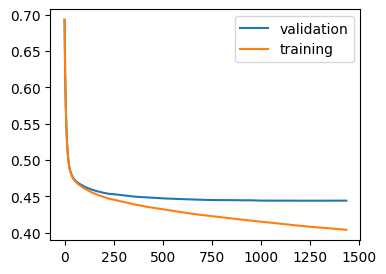

In [43]:
plt.figure(figsize=(4,3))
plt.plot(-model.validation_score_, label='validation')
plt.plot(-model.train_score_, label='training')
plt.legend()
plt.show()

In [44]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

    Approved       0.87      0.84      0.86     44078
      Denied       0.71      0.76      0.74     22784

    accuracy                           0.81     66862
   macro avg       0.79      0.80      0.80     66862
weighted avg       0.82      0.81      0.82     66862



## AdaBoost

In [17]:
from sklearn.ensemble import AdaBoostClassifier

In [18]:
model_adaboost = AdaBoostClassifier().fit(X_train_total, y_train_total)

/home/henrique/mlai-course/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [19]:
model_adaboost.score(X_test_total, y_test_total)

0.7958182525201161